In [3]:
!pip install -q web3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 580.1/580.1 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.3/157.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.1 MB/s eta 0:00:00


In [10]:
from web3 import Web3
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
from requests.exceptions import HTTPError

In [5]:
INFURA_PROJECT_ID = 'f25af56bef3b4460a475fd5ddc05b227'
EtherscanAPIKey = 'UTEEDACWRBK85VNRBDZF6KFKAMG18WQ7MK'

w3 = Web3(Web3.HTTPProvider(f'https://mainnet.infura.io/v3/{INFURA_PROJECT_ID}'))
print(w3.is_connected())

True


In [6]:
uniswap_v1_pool_address = '0x4F30E682D0541eAC91748bd38A648d759261b8f3'
uniswap_v2_pool_address = '0xb4d0d9df2738abE81b87b66c80851292492D1404'

def get_contract_abi(pool_address):
    pool_abi_url = f"https://api.etherscan.io/api?module=contract&action=getabi&address={pool_address}&apikey={EtherscanAPIKey}"
    response = requests.get(pool_abi_url)
    return json.loads(response.json()['result'])

uniswap_v1_pool_contract = w3.eth.contract(address=uniswap_v1_pool_address, abi=get_contract_abi(uniswap_v1_pool_address))
uniswap_v2_pool_contract = w3.eth.contract(address=uniswap_v2_pool_address, abi=get_contract_abi(uniswap_v2_pool_address))

In [7]:
start_time = datetime(2022, 1, 23)
end_time = start_time + timedelta(days=1)

start_timestamp = int(start_time.timestamp())
end_timestamp = int(end_time.timestamp())

response_start = requests.get(
    f"https://api.etherscan.io/api?module=block&action=getblocknobytime&timestamp={start_timestamp}&closest=before&apikey={EtherscanAPIKey}"
)
start_block_number = json.loads(response_start.json()['result'])

response_end = requests.get(
    f"https://api.etherscan.io/api?module=block&action=getblocknobytime&timestamp={end_timestamp}&closest=before&apikey={EtherscanAPIKey}"
)
end_block_number = json.loads(response_end.json()['result'])

print(f"Start block number: {start_block_number}")
print(f"End block number: {end_block_number}")

Start block number: 14058540
End block number: 14064996


In [11]:
v1_prices = []
v2_prices = []
timestamps = []

for block_number in range(start_block_number, end_block_number + 1, 60):
    try:
        block = w3.eth.get_block(block_number)
        timestamp = datetime.fromtimestamp(block['timestamp'])

        eth_amount = Web3.to_wei(1, 'ether')
        tusd_amount_out_v1 = uniswap_v1_pool_contract.functions.getEthToTokenInputPrice(eth_amount).call(block_identifier=block_number)
        price_per_eth_v1 = tusd_amount_out_v1 / eth_amount
        v1_prices.append(price_per_eth_v1)

        tusd_amount_out_v2, weth_amount_out_v2, _ = uniswap_v2_pool_contract.functions.getReserves().call(block_identifier=block_number)
        price_per_eth_v2 = tusd_amount_out_v2 / weth_amount_out_v2
        v2_prices.append(price_per_eth_v2)

        timestamps.append(timestamp)

        time.sleep(0.5)
    except HTTPError as e:
        print(f"HTTP Error: {e}")
        time.sleep(10)

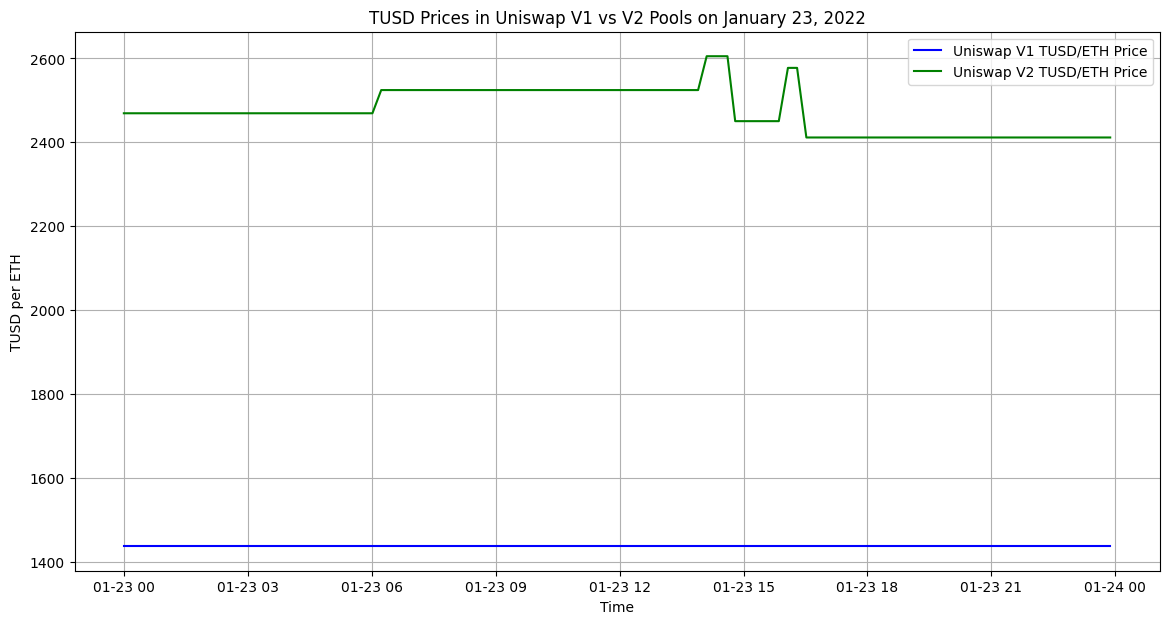

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(timestamps, v1_prices, label='Uniswap V1 TUSD/ETH Price', color='blue')
plt.plot(timestamps, v2_prices, label='Uniswap V2 TUSD/ETH Price', color='green')
plt.xlabel('Time')
plt.ylabel('TUSD per ETH')
plt.title('TUSD Prices in Uniswap V1 vs V2 Pools on January 23, 2022')
plt.legend()
plt.grid(True)
plt.show()